https://hongl.tistory.com/99

![](attachment:3cc66625-7ba1-4f4c-909d-d3c30786c0b5.png)

In [66]:
pip install --user pmdarima

ERROR! Session/line number was not unique in database. History logging moved to new session 102
Note: you may need to restart the kernel to use updated packages.


In [67]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from pmdarima.arima import auto_arima
from pmdarima.arima import ndiffs

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [68]:
data = pd.read_csv('data/electricity.csv')
data

,Residential,Commercial,Industrial,Total,dates
0,3078100.0,2016100.0,2425400.0,7770200.0,1990-01-01
1,2660700.0,2032600.0,2664500.0,7620100.0,1990-02-01
2,2319400.0,1870300.0,2478800.0,6905400.0,1990-03-01
3,2173000.0,1882700.0,2541300.0,6835700.0,1990-04-01
4,2028400.0,1901300.0,2540600.0,6714600.0,1990-05-01
...,...,...,...,...,...
310,3079400.0,3464700.0,2545900.0,9110300.0,2015-11-01
311,3581700.0,3429430.0,2449100.0,9480300.0,2015-12-01
312,4219200.0,3559200.0,2460900.0,10260000.0,2016-01-01
313,3997000.0,3563400.0,2561800.0,10145000.0,2016-02-01


In [69]:
df = data[['dates','Total']]

df = df.rename(columns = {
    'Total':'total'
})

df['dates'] = pd.to_datetime(df['dates'])

df['year'] = df['dates'].dt.year

df9703 = df.query('year >= 1997 & year <= 2003')

df9703 = df9703.set_index('dates', drop=True)

df9703 = df9703[['total']]

df9703

,total
dates,
1997-01-01,8882200.0
1997-02-01,8959500.0
1997-03-01,7854700.0
1997-04-01,7826900.0
1997-05-01,7636900.0
...,...
2003-08-01,11026000.0
2003-09-01,10220000.0
2003-10-01,8947700.0


In [70]:
me = df9703

In [71]:
split = int(0.7*len(me)) #7:3 비율

train = me[:split] #학습
test = me[split:] #예측

print(len(train), len(test))

58 26


In [72]:
def adf_test(dt):
    stat, p_value, lags, nobs, crit, icb = adfuller(dt)
    print('p_value :', p_value)
    return p_value

In [73]:
p_v = adf_test(train)

p_value : 0.5441961750948482


In [74]:
d = 0

n_diffs : 1
p_value : 0.07021480968137404
diff p_value : 0.07021480968137404
p_value : 0.03904550427976579
log p_value : 0.03904550427976579


C:\Users\mirae\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


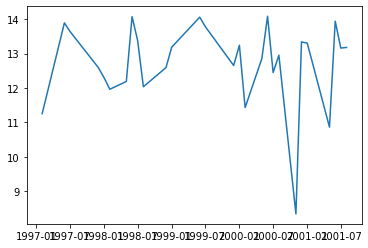

good


In [75]:
if p_v > 0.05:
    kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
    adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
    n_diffs = max(adf_diffs, kpss_diffs)
    
    print('n_diffs :', n_diffs)
    
    if n_diffs>0:
        d = n_diffs
        
        diff_train = train.diff(d)
        
        diff_train = diff_train.dropna(axis=0)
        
        diff_p_v = adf_test(diff_train)
        print('diff p_value :', diff_p_v) #대부분 여기서 0.05 이하로 나오지 않을까
        
        if diff_p_v > 0.05: #분산 일정x 경우
            log_train = np.log(diff_train) 
            # 오류해결방법..
            # RuntimeWarning: invalid value encountered in log result = func(self.values, **kwargs)
            #
            
            log_train = log_train.dropna(axis=0)

            log_p_v = adf_test(log_train)
            print('log p_value :', log_p_v) 
            
            plt.plot(log_train)
            plt.show()               
            
            if ((log_p_v) > 0.05): #이건
                print('?????????????????????????')
            else:
                print('good')

In [76]:
def autoarima(train):
    
    model = 0
    ex = 99999 
    m = 1
    
    for m_test in [1, 7, 12]: #52까지 하면 웹꺼짐..추가 입력을 받자..
        arima = auto_arima(
                    y = train, 
                    d = d, 
                    m = m_test, 
                    seasonal = True, 
                    trace = True
                )
        if arima.aic() < ex:
            ex = arima.aic()
            models = arima
            m = m_test
            
    return [models, m]

In [77]:
model, m = autoarima(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1694.981, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1695.041, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1693.903, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1692.992, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1698.275, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.872 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=1640.732, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1694.981, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1695.621, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1694.456, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1692.992, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=0.5

In [78]:
model

ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

SARIMAX

https://towardsdatascience.com/time-series-forecasting-with-sarima-in-python-cda5b793977b

In [ ]:
if model.seasonal_order == (0,0,0,0):
    
    arima = ARIMA(model.order)
    
else:
    
    arima = SARIMA()

In [ ]:
order = model.order
season_order

In [ ]:
arima = ARIMA()